In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.jsonhttps://www.kaggle.com/paultimothymooney/breast-histopathology-images
!kaggle datasets download paultimothymooney/breast-histopathology-images

100% 3.09G/3.10G [01:22<00:00, 41.6MB/s]
100% 3.10G/3.10G [01:22<00:00, 40.5MB/s]


In [ ]:
!pip install split-folders tqdm

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
%tensorflow_version 2.x
import os
import shutil
from random import shuffle
#import split_folders
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras
import time
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, Activation, LeakyReLU
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import split_folders
import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import tensorflow_addons as tfa

In [ ]:
path = os.getcwd()

In [ ]:
archive = zipfile.ZipFile(path + '/breast-histopathology-images.zip')

for file in archive.namelist():
    if file.startswith('IDC_regular_ps50_idx5/'):
        archive.extract(file, path + '/photos')

In [ ]:
base_path = '/content/photos/IDC_regular_ps50_idx5'
patient_ids = os.listdir(base_path)
print(len(patient_ids))


279


In [ ]:
# create empty directories for AllPhotos 
outputPath = '/content/AllPhotos/'
os.mkdir(outputPath)
outPutclass0 = outputPath + 'class_0'
os.mkdir(outPutclass0)
outPutclass1 = outputPath + 'class_1'
os.mkdir(outPutclass1)
os.mkdir('/content/SplittedFolders')

In [ ]:
class_0_total = 0
class_1_total = 0
for patient_id in patient_ids:
    # adding double \\ because otherwise python recocnize it as escape character. 
    # example of class_0_files path : C:\Users\Marios\Desktop\BachelorThesis\Final\photos\10253\0
    # class 0 consists of file that are Non-Invasive Ductal Carcinoma (IDC) and class 1 Invasive Ductal Carcinoma (IDC).
    patient_path_class0 = base_path + "/" + patient_id + '/0'
    patient_path_class1 = base_path + "/" + patient_id + '/1'
    class_0_files = os.listdir(patient_path_class0)
    class_1_files = os.listdir(patient_path_class1)
    class_0_total += len(class_0_files)
    class_1_total += len(class_1_files) 
    # copy all images to AllPhotos in order to split them.
    for file_name in class_0_files:
        full_file_name = os.path.join(patient_path_class0, file_name)
        shutil.copy(full_file_name, outputPath + 'class_0')
    for file_name in class_1_files:
        full_file_name = os.path.join(patient_path_class1, file_name)
        shutil.copy(full_file_name, outputPath + 'class_1')
total_images = class_0_total + class_1_total
    
print(f'Number of patches in Class 0: {class_0_total}')
print(f'Number of patches in Class 1: {class_1_total}')
print(f'Total number of patches: {total_images}')

Number of patches in Class 0: 198738
Number of patches in Class 1: 78786
Total number of patches: 277524


In [ ]:
# 80-10-10 % train, (validate) / test split.
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
pathToImages = '/content/SplittedFolders'
split_folders.ratio(outputPath, output= pathToImages, seed=1337, ratio=(.8, .1, .1)) # default values

Copying files: 277524 files [01:23, 3313.22 files/s]


In [ ]:
# set up variables to use while pre-processing the dataset and training the network.
seed = 2
batch_size = 64
epochs = 100
IMG_HEIGHT = 50
IMG_WIDTH = 50
COLOR_DEPTH = 3
METRICS = [
      #tf.keras.metrics.FalsePositives(name = 'FP'),
      #tf.keras.metrics.TruePositives(name = 'TP'),
      #tf.keras.metrics.FalseNegatives(name = 'FN'),
      #tf.keras.metrics.TrueNegatives(name = 'TN'),
      #tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
     tfa.metrics.F1Score(num_classes = 1,average = None, threshold = 0.5 )
]


In [ ]:
# rescales the pixels from 0 to 255 to 0 to 1 in order to
# normalize them and feed them into our NN.
train_image_generator = ImageDataGenerator(rescale=1./255
                                          #horizontal_flip=True,
                                          #vertical_flip=True,
                                          #rotation_range=90
                                          )  
# Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data
# the flow_from_directory method load images from the disk,
# applies rescaling, and resizes the images into the required dimensions and make batches of 128 elements.
train_dir = '/content/SplittedFolders/train'
validation_dir = '/content/SplittedFolders/val'
test_dir = '/content/SplittedFolders/test'
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary',
                                                           seed = seed)
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary',
                                                              seed = seed)


Found 222018 images belonging to 2 classes.
Found 27751 images belonging to 2 classes.


In [ ]:
def plotImages(images_arr):
    # 1 row, 5 columns and 20x20 each figure.
    fig, axes = plt.subplots(1, 5, figsize=(15, 15))
    # axes. flatten makes the 2D figures into 1D
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        # dont display the axis.(x, y)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

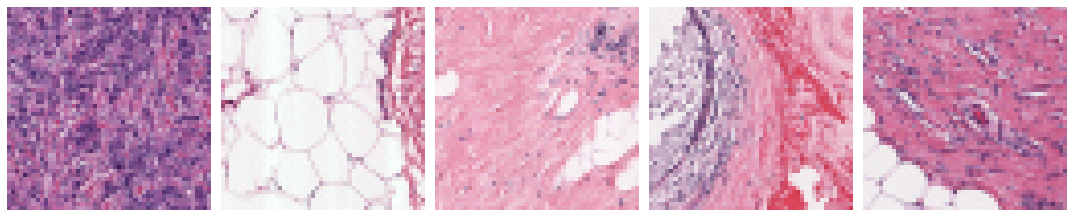

In [ ]:
# visualize data, next will get the first item of the iterative(train_data_gen)
# and it will be length of the batch size. Also it will give back the training
# labels(variable _) and because we dont need it we discard it.
sample_training_images, _ = next(train_data_gen)
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
plotImages(sample_training_images[:5])

In [ ]:
train_images = len(os.listdir(train_dir + '/class_0')) + len(os.listdir(train_dir + '/class_1'))
total_val_images = len(os.listdir(validation_dir + '/class_0')) + len(os.listdir(validation_dir + '/class_1'))

In [ ]:
model = Sequential([
                    Conv2D(32, 3, padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, COLOR_DEPTH)),
                    BatchNormalization(),
                    #LeakyReLU(alpha=0.05),
                    Activation('relu'),
                    MaxPooling2D(),
                    Conv2D(64, 3, padding='same'),
                    BatchNormalization(),
                    #LeakyReLU(alpha=0.05),
                    Activation('relu'),
                    MaxPooling2D(),
                    Conv2D(128, 3, padding='same'),
                    BatchNormalization(),
                    #LeakyReLU(alpha=0.05),
                    Activation('relu'),
                    MaxPooling2D(),
                    Conv2D(256, 3, padding='same'),
                    BatchNormalization(),
                    #LeakyReLU(alpha=0.05),
                    Activation('relu'),
                    #MaxPooling2D(),
                    #Dropout(0.2),
                    Flatten(),
                    Dense(128),
                    #LeakyReLU(alpha=0.05),
                    BatchNormalization(),
                    Activation('relu'),
                    Dropout(0.2),
                    Dense(64),
                    #LeakyReLU(alpha=0.05),
                    BatchNormalization(),
                    Activation('relu'),
                    #Dropout(0.2),
                    # Dense(1024),
                    # BatchNormalization(),
                    # #LeakyReLU(alpha=0.05),
                    # Activation('relu'),
                    #Dropout(0.2),
                    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
batch_normalization_31 (Batc (None, 50, 50, 32)        128       
_________________________________________________________________
activation_31 (Activation)   (None, 50, 50, 32)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
batch_normalization_32 (Batc (None, 25, 25, 64)        256       
_________________________________________________________________
activation_32 (Activation)   (None, 25, 25, 64)       

In [ ]:
# SAVE weights in order to reinitialize without change names.
from tensorflow.keras import optimizers
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics = METRICS)
# simple early stopping
#es = EarlyStopping(monitor='val_f1_score', mode='max', verbose=1, patience = 3)
mc = ModelCheckpoint('best_model.h5', monitor='val_f1_score', mode='max', verbose=1, save_best_only=True)
# train our model.
start = time.time()
model.save('temp_model.h5')
history = model.fit(
    train_data_gen,
    steps_per_epoch=train_images // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val_images // batch_size,
    callbacks = [mc]
)

print('Time taken for training : ', time.time() - start)

In [ ]:
model.load_weights('64BatchAdamAlgorithmConv32_64_128_256BNReLUMaxPooling(Nolastlayer)Dense(128dropout0.2,64)F1SCORE_0.807Epoch18.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# \ is escape charcther for My Drive
!mv best_model.h5 /content/drive/My\ Drive/BestModels/

In [ ]:

# Now visualize the results after training the network
recall = history.history['recall']
val_recall = history.history['val_recall']

precision = history.history['precision']
val_precision = history.history['val_precision']

epochs_range = range(11)

In [ ]:
# Now visualize the results after training the network
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# alternatively fig, axes = plt.subplots(1,2, figsize=(8, 8))
# for ax in axes:
#   ax.plot()...
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, recall, label='Training Recall')
plt.plot(epochs_range, val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, precision, label='Training Precision')
plt.plot(epochs_range, val_precision, label='Validation Precision')
plt.legend(loc='upper right')
plt.title('Training and Validation Precision')
plt.show()

In [ ]:
val_data_generator =  ImageDataGenerator(rescale = 1./255)
val_data_gen = val_data_generator.flow_from_directory(batch_size=batch_size,
                                                              directory= validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode= None)

import math
# we get a little bit different results as far as FP,TP,FN,TN is concerned because the total_val_images aren't an exact divisor of batch_size
probabilities = model.predict(val_data_gen, steps = math.ceil(total_val_images// batch_size) + 1, verbose = 1)

from sklearn.metrics import confusion_matrix, classification_report

y_pred = probabilities >= 0.5
labels = [1,0]
conf = confusion_matrix(val_data_gen.classes,y_pred, labels)


tn, fp, fn, tp = conf.ravel()
print('TN:', tn,'FP:', fp,'FN:', fn,'TP:', tp)

reg_conf = np.array([[tp,fp],[fn,tn]])
print(reg_conf)
#print f_score and recall bla bla
print(classification_report(val_data_gen.classes, y_pred))
#val_loss: 0.9149 - val_FP: 303.0000 - #val_TP: 2495.0000 - val_FN: 5344.0000 - val_TN: 19570.0000 - 
#val_accuracy: 0.7962 - val_precision: 0.8917 - val_recall: 0.3183 - val_auc: 0.8351 - val_f1_score: 0.4691

Found 27751 images belonging to 2 classes.
434/434 [==============================] - 10s 23ms/step
TN: 6743 FP: 1135 FN: 2148 TP: 17725
[[17725  1135]
 [ 2148  6743]]
              precision    recall  f1-score   support

           0       0.94      0.89      0.92     19873
           1       0.76      0.86      0.80      7878

    accuracy                           0.88     27751
   macro avg       0.85      0.87      0.86     27751
weighted avg       0.89      0.88      0.88     27751



Text(0.5, 1.0, 'Confusion Matrix')

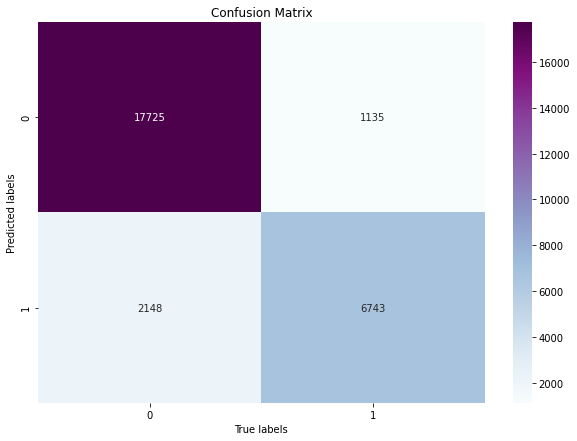

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))  
sn.heatmap(reg_conf,annot=True,cmap='BuPu', fmt='g', ax = ax)
# labels, title and ticks
# 0 is not cancer 1 is cancer
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels') 
ax.set_title('Confusion Matrix')

In [ ]:
test_data_generator =  ImageDataGenerator(rescale = 1./255)
test_data_gen = test_data_generator.flow_from_directory(batch_size=batch_size,
                                                              directory= test_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')
probabilities = model.predict(test_data_gen,steps = len(test_data_gen.filenames)//batch_size + 1, verbose = 1)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


y_pred = probabilities > 0.5
labels = [1,0]
from sklearn.metrics import classification_report
conf = confusion_matrix(test_data_gen.classes,y_pred, labels)
tn, fp, fn, tp = conf.ravel()
print('TN:', tn,'FP:', fp,'FN:', fn,'TP:', tp)

reg_conf = np.array([[tp,fp],[fn,tn]])
print(reg_conf)
# print f_score and recall bla bla
print(classification_report(test_data_gen.classes, y_pred, digits = 5))

Found 27755 images belonging to 2 classes.
434/434 [==============================] - 10s 22ms/step
TN: 6433 FP: 1447 FN: 1669 TP: 18206
[[18206  1447]
 [ 1669  6433]]
              precision    recall  f1-score   support

           0    0.92637   0.91603   0.92117     19875
           1    0.79400   0.81637   0.80503      7880

    accuracy                        0.88773     27755
   macro avg    0.86019   0.86620   0.86310     27755
weighted avg    0.88879   0.88773   0.88820     27755



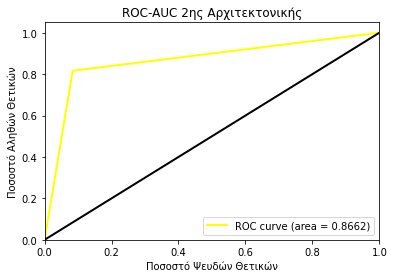

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = metrics.roc_curve(test_data_gen.classes, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='yellow', lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ποσοστό Ψευδών Θετικών')
plt.ylabel('Ποσοστό Αληθών Θετικών')
plt.title('ROC-AUC 2ης Αρχιτεκτονικής')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, 'Πίνακας Σύγχισης')

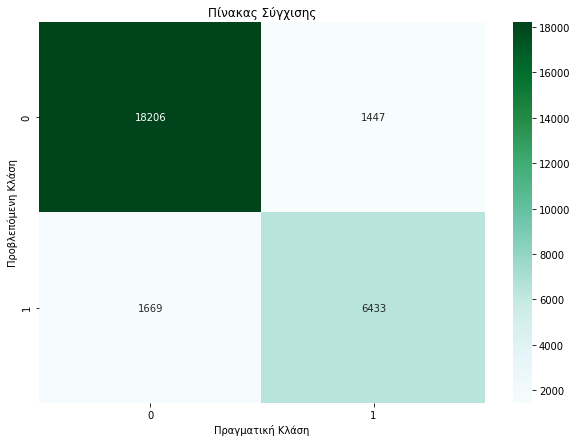

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))  
sn.heatmap(reg_conf,annot=True,cmap='BuGn', fmt='g', ax = ax)
# labels, title and ticks
# 0 is not cancer 1 is cancer
ax.set_xlabel('Πραγματική Κλάση')
ax.set_ylabel('Προβλεπόμενη Κλάση') 
ax.set_title('Πίνακας Σύγχισης')